<a href="https://colab.research.google.com/github/marcelogarret/projeto_mestrado/blob/main/LSTM_garret_JAX_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --upgrade pip
%pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html optax flax

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
import flax.linen as nn
from flax.training.train_state import TrainState
import optax
from functools import partial

In [229]:
## Importação do histórico - UNISIM
df = pd.read_excel('/content/drive/MyDrive/UNISIM/dataset_unisim.xlsx')
df.head()

,t,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
0,0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
1,31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
2,62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
3,92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
4,123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327


In [230]:
df.shape

(132, 11)

In [231]:
df.index = df['t']
t = df['t'].values[:-1]
df.drop('t', axis=1, inplace=True)
df

,Np,Gp,Wp,Winj,Bo,Bg,Rs,Viso,Visg,p
t,,,,,,,,,,
0,0,0,0,0,1.394241,0.003249,113.06,0.638284,0.027344,332
31,61938,6858068,0,0,1.394403,0.003260,113.06,0.640304,0.027288,331
62,124403,13532213,0,0,1.394727,0.003281,113.06,0.644361,0.027178,329
92,182423,20112443,0,0,1.394889,0.003291,113.06,0.646399,0.027122,328
123,244857,26856741,0,0,1.395051,0.003302,113.06,0.648443,0.027067,327
...,...,...,...,...,...,...,...,...,...,...
3867,24757936,2793256452,4393983,36864922,1.398615,0.003554,113.06,0.695071,0.025850,305
3896,25022300,2822363056,4583991,37475894,1.398453,0.003542,113.06,0.692879,0.025905,306
3927,25304090,2853787229,4789676,38123794,1.398291,0.003530,113.06,0.690695,0.025960,307


In [242]:
npp=df["Np"].values[1:]
gp=df["Gp"].values[1:]/1000
wp=df["Wp"].values[1:]
winj=df["Winj"].values[1:]
bo=df["Bo"].values[1:]
bg=df["Bg"].values[1:]
rs=df["Rs"].values[1:]
viso=df["Viso"].values[1:]
visg=df["Visg"].values[1:]
p=df["p"].values[1:]

In [243]:
from sklearn.preprocessing import MinMaxScaler

# Separar as características (todas as colunas exceto a última) e o rótulo (última coluna)
features = df.iloc[:, :-1]  # Todas as colunas menos a última
labels = df.iloc[:, -1]     # Última coluna

# Normalize as características
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Combine as características normalizadas e a coluna de rótulos não normalizada
scaled_data = np.concatenate([scaled_features, labels.values.reshape(-1, 1)], axis=1)
# scaled_data = df.to_numpy()

# Define sequence length and features
window_size = 1  # Number of time steps in each sequence
features_count = len(df.columns)
scaled_data.shape, labels

((132, 10),
 t
 0       332
 31      331
 62      329
 92      328
 123     327
        ... 
 3867    305
 3896    306
 3927    307
 3957    308
 3988    309
 Name: p, Length: 132, dtype: int64)

In [244]:
# Create sequences and corresponding labels
X = []
y = []
for i in range(len(scaled_data) - window_size):
    seq = scaled_data[i:i+window_size]
    label = scaled_data[i+window_size][-1]
    X.append(seq)
    y.append(label)

In [245]:
# Convert to jax numpy arrays
X = jnp.array(X)
y = jnp.array(y)
X.shape, y.shape

((131, 1, 10), (131,))

In [246]:
train_size = int(0.9 * len(X))
val_size = int(0.05 * len(X))
test_size = len(X) - train_size - val_size
train_size, val_size, test_size

(117, 6, 8)

In [247]:
# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
# X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
X_train, X_val, X_test = X, X, X
y_train, y_val, y_test = y, y, y


X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((131, 1, 10), (131,), (131, 1, 10), (131,), (131, 1, 10), (131,))

In [248]:
X_train[0], y_train[0], p[0]

(Array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 332.]],      dtype=float32),
 Array(331., dtype=float32),
 331)

In [265]:
# Definir a rede LSTM usando Flax
class LSTM(nn.Module):
    @nn.compact
    def __call__(self, x):
        input_shape = x[0].shape

        lstm1 = nn.OptimizedLSTMCell(128)
        lstm2 = nn.OptimizedLSTMCell(64)
        lstm3 = nn.OptimizedLSTMCell(32)

        carry1 = lstm1.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry2 = lstm2.initialize_carry(jax.random.PRNGKey(0), input_shape)
        carry3 = lstm3.initialize_carry(jax.random.PRNGKey(0), input_shape)

        for i in range(x.shape[0]):
          if i < (x.shape[0] - 1):
            carry1, out1 = lstm1(carry1, x[i])
            carry2, out2 = lstm2(carry2, out1)
            carry3, _ = lstm3(carry3, out2)
          else:
            _, out1 = lstm1(carry1, x[i])
            _, out2 = lstm2(carry2, out1)
            _, x = lstm3(carry3, out2)

        x = nn.Dense(8)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

# Initialize the random key
rng_key = random.PRNGKey(42)

class LSTMnet(LSTM):
    def setup(self):
        super().setup()
        self.N = self.param("N", jax.nn.initializers.constant(130.0), ())
        self.Wi = self.param("Wi", jax.nn.initializers.constant(100.0), ())
        self.J = self.param("J", jax.nn.initializers.constant(10.0), ())

# Define the Neural Network
model = LSTMnet()

# Initialize the model parameters
rng_key, init_key = random.split(rng_key, 2)
dummy_input = jnp.zeros(X_train[0].shape)
params = model.init(init_key, dummy_input)

## Define the optimizer using Optax
# lr = 0.01
lr = optax.exponential_decay(init_value=1e-3,
                             transition_steps=5000,
                             decay_rate=0.98)
tx = optax.adam(learning_rate=lr)

# Create the training state
state = TrainState.create(
    apply_fn=lambda params_, x_: model.apply(params_, x_)[0],
    # apply_fn=model.apply,
    params=params,
    tx=tx)

# Print the model structure in a fancy way
print(model.tabulate(rng_key, dummy_input))


                                          LSTMnet Summary                                           
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ path              ┃ module            ┃ inputs           ┃ outputs           ┃ params            ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│                   │ LSTMnet           │ float32[1,10]    │ float32[1]        │ J: float32[]      │
│                   │                   │                  │                   │ N: float32[]      │
│                   │                   │                  │                   │ Wi: float32[]     │
│                   │                   │                  │                   │                   │
│                   │                   │                  │                   │ 3 (12 B)          │
├───────────────────┼───────────────────┼──────────────────┼───────────────────┼──────────

In [266]:
# Imprimindo os parametros a serem ajustados
state.params['params']['N'], state.params['params']['Wi'], state.params['params']['J']

(Array(130., dtype=float32),
 Array(100., dtype=float32),
 Array(10., dtype=float32))

The solution for p(t=[[  0.   0.   0.   0.   0.   0.   0.   0.   1. 332.]]) = 0.002839380409568548


Text(0.5, 1.0, 'Previsão antes do ajuste do modelo')

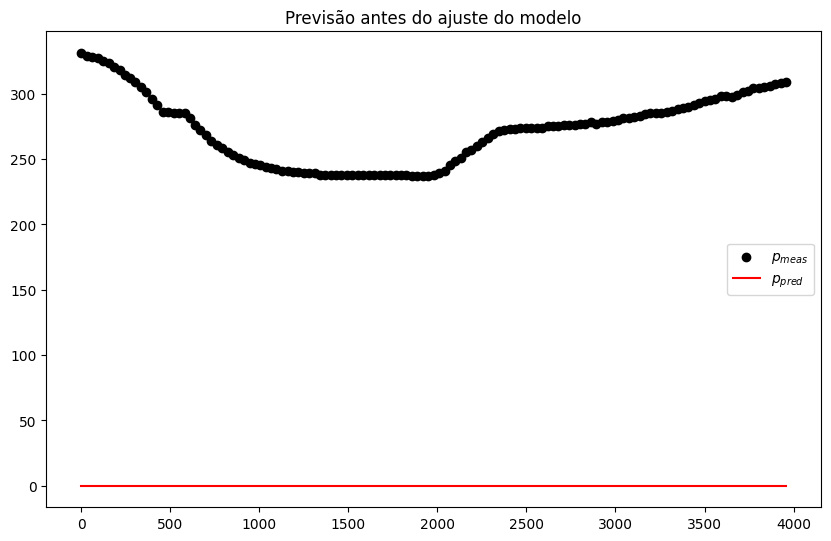

In [267]:
# Avaliando o modelo para um único vetor de entrada
x_single = X_train[0]
u_pred = state.apply_fn(params, x_single)
print(f"The solution for p(t={x_single}) = {u_pred}")

# Avaliando a rede neural antes do treinamento considerando todo o histórico
u_pred = vmap(state.apply_fn, (None, 0))(state.params, X_train)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(t, p, label=r'$p_{meas}$', color='black')
ax.plot(t, u_pred, label=r'$p_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão antes do ajuste do modelo')

In [268]:
## Parametros escalares (MODSI)
# phi = 0.13
# k = 77
m = 0.0
Rsi = 113.06
Bw = 1.0210
uw = 0.3
cf = 5.3E-05
p0 = 332.00
pb = 210.03
bob = 1.414
co = 1.62E-04
cw = 4.76E-05
Swi = 0.17
Sor = 0.18
Sgc = 0.05

In [270]:
@jit
def train_step(state, batch):
    def phy_residual_fn(params, u):
        # Aplicar limites nos parâmetros
        N = jnp.clip(params['params']['N'], 0.0, 300.0)  # Limita N entre 0 e 300
        Wi = jnp.clip(params['params']['Wi'], 100.0, 1000.0)  # Limita Wi entre 100 e 1000
        J = jnp.clip(params['params']['J'], 1.0, 100.0)  # Limita J entre 1 e 100

        #EBM
        rp = gp  / jnp.where(npp != 0, npp, 1.0) * 1000
        F = npp * (bo + (rp-rs) * bg) + (wp - winj) * Bw
        Eo = bo - bo[0] + (Rsi - rs) * bg
        Eg = bo[0] * ((bg / bg[0]) - 1)
        Efw = (1 + m) * bo[0] * ((cf + cw * Swi)/(1 - Swi)) * (u[0] - u)
        We_EBM = F - (N * 10**6) * (Eo + m * Eg + Efw)

        #Aquif
        Wei = (cf + cw) * Wi * u[0] * 10**6
        Wen = jnp.zeros(len(t))
        dt = jnp.diff(t)
        dt = jnp.insert(dt, 0, 0.0)
        pa_med = jnp.zeros(len(t))
        pa_med = pa_med.at[0].set(u[0])
        for i in range(1,len(t)):
          pa_med = pa_med.at[i-1].set(u[0] *(1 - (Wen[i-1] / Wei)))
          Wen = Wen.at[i].set(Wen[i-1] + (Wei / u[0]) * (pa_med[i-1] - u[i]) * (1 - jnp.exp(-J * u[0] * dt[i] / Wei)))

        res = (We_EBM - Wen) / 10**6
        # res = 0.0
        return res

    def loss_fn(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        res_pred = phy_residual_fn(params, u_pred)
        phy_loss = jnp.mean(res_pred ** 2) ** 0.5
        data_loss = jnp.mean(jnp.square(u_pred - batch['u']))
        total_loss = 1.0 * data_loss + 1.0 * phy_loss
        return total_loss, {
            "total_loss": total_loss,
            "data_loss": data_loss,
            "phy_loss": phy_loss,
        }

    # Compute the loss and its grads w.r.t. the model parameters
    (_, loss_components), grads = value_and_grad(loss_fn, has_aux=True)(
        state.params, batch
    )
    state = state.apply_gradients(grads=grads)
    return loss_components, state

@jit
def eval_step(state, batch):
    def eval_error(params, batch):
        u_pred = vmap(state.apply_fn, (None, 0))(params, batch['x'])
        # return jnp.linalg.norm(x=(u_pred - batch['u']), ord=2) / jnp.linalg.norm(x=batch['u'], ord=2)
        return jnp.mean(jnp.square(u_pred - batch['u']))
    return eval_error(state.params, batch)

In [271]:
train_batch = {'x': X_train, 'u': y_train}
eval_batch = {'x': X_val, 'u': y_val}

In [272]:
total_loss_log = []
data_loss_log = []
phy_loss_log = []
epoch_log = []
error_log = []
N_log = []
Wi_log = []
J_log = []

epochs = 150000

for epoch in range(epochs):
  loss, state = train_step(state, train_batch)
  if epoch%100 == 0:
    epoch_log.append(epoch)
    N_est = state.params["params"]["N"]
    Wi_est = state.params["params"]["Wi"]
    J_est = state.params["params"]["J"]
    total_loss_log.append(loss['total_loss'])
    data_loss_log.append(loss['data_loss'])
    phy_loss_log.append(loss['phy_loss'])
    eval_error = eval_step(state, eval_batch)
    error_log.append(eval_error)
    N_log.append(N_est)
    Wi_log.append(Wi_est)
    J_log.append(J_est)
    print(f"Epoch: {epoch} -- Total Loss: {loss['total_loss']:0.6f}  -- Data Loss: {loss['data_loss']:0.6f} -- Physics Loss: {loss['phy_loss']:0.6f} -- Error: {eval_error:0.4f} -- N: {N_est:0.2f} -- Wi: {Wi_est:0.2f} -- J: {J_est:0.2f}")

Epoch: 0 -- Total Loss: 74832.976562  -- Data Loss: 74830.492188 -- Physics Loss: 2.484874 -- Error: 74825.3984 -- N: 130.00 -- Wi: 100.00 -- J: 10.00
Epoch: 100 -- Total Loss: 71697.226562  -- Data Loss: 71694.742188 -- Physics Loss: 2.483816 -- Error: 71655.6328 -- N: 130.10 -- Wi: 100.00 -- J: 10.02
Epoch: 200 -- Total Loss: 67256.914062  -- Data Loss: 67254.429688 -- Physics Loss: 2.482779 -- Error: 67203.6016 -- N: 130.20 -- Wi: 100.00 -- J: 10.02
Epoch: 300 -- Total Loss: 61517.843750  -- Data Loss: 61515.363281 -- Physics Loss: 2.481746 -- Error: 61451.6836 -- N: 130.30 -- Wi: 100.00 -- J: 10.02
Epoch: 400 -- Total Loss: 54644.210938  -- Data Loss: 54641.730469 -- Physics Loss: 2.480712 -- Error: 54568.5195 -- N: 130.40 -- Wi: 100.00 -- J: 10.02
Epoch: 500 -- Total Loss: 47028.281250  -- Data Loss: 47025.800781 -- Physics Loss: 2.479679 -- Error: 46947.4062 -- N: 130.50 -- Wi: 100.00 -- J: 10.03
Epoch: 600 -- Total Loss: 39123.640625  -- Data Loss: 39121.160156 -- Physics Loss: 

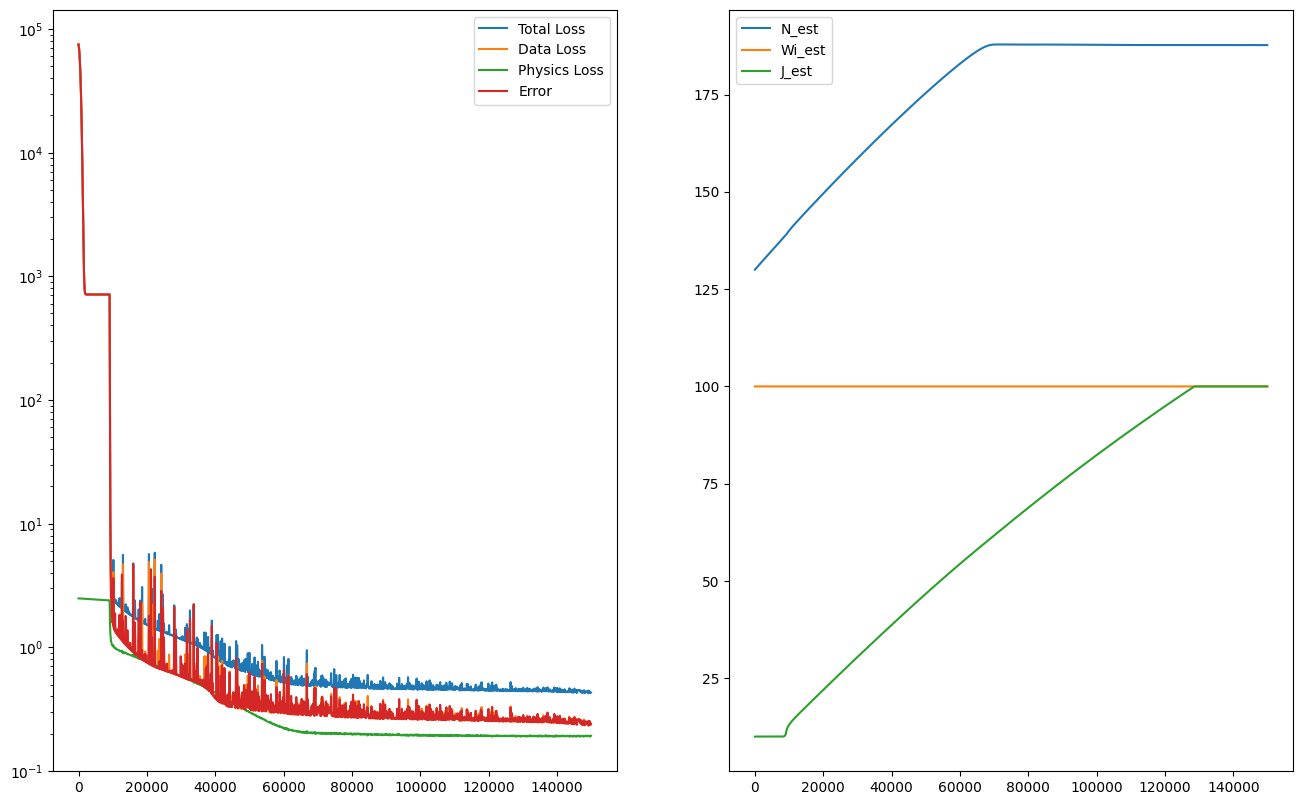

In [273]:
# Plot training & validation loss values
fig, axs = plt.subplots(1, 2, figsize=(16, 16 / 1.618))

axs[0].plot(epoch_log, total_loss_log, label="Total Loss")
axs[0].plot(epoch_log, data_loss_log, label="Data Loss")
axs[0].plot(epoch_log, phy_loss_log, label="Physics Loss")
axs[0].plot(epoch_log, error_log, label="Error")
axs[0].set_yscale("log")
axs[0].legend()

axs[1].plot(epoch_log, N_log, label="N_est")
axs[1].plot(epoch_log, Wi_log, label="Wi_est")
axs[1].plot(epoch_log, J_log, label="J_est")
axs[1].legend()

In [276]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict temperatures using the trained model
predictions = vmap(state.apply_fn, (None, 0))(state.params, X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.35586944
Mean Squared Error (MSE): 0.24378355
Root Mean Squared Error (RMSE): 0.4937444


Text(0.5, 1.0, 'Previsão depois do ajuste do modelo')

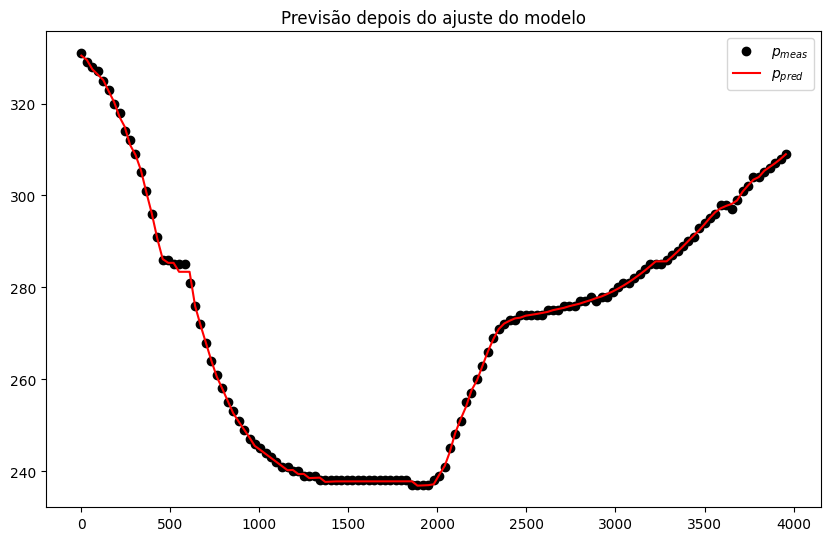

In [277]:
# Avaliando a rede neural depois do treinamento considerando todo o histórico
u_pred = vmap(state.apply_fn, (None, 0))(state.params, X_train)

fig, ax = plt.subplots(1,1, figsize=(10,10/1.618))

ax.scatter(t, p, label=r'$p_{meas}$', color='black')
ax.plot(t, u_pred, label=r'$p_{pred}$', color='red')

ax.legend()
ax.set_title('Previsão depois do ajuste do modelo')